In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable as stb
import warnings 
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', None)

import datetime as dt
warnings.filterwarnings('ignore')


### Basic Understanding of The Data

In [2]:
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [4]:
df.isna().sum()

# there are some columns with null value in the data frame we will need to imputing, and filling some random value 
# and there's huge amount of missing value in the company column this might need to be drop, but we will discover it later on


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [5]:
df['is_canceled'].value_counts(normalize=True)

# The data is not imbalance so for the accuracy score will be considered as evaluation matrix score 

0    0.629584
1    0.370416
Name: is_canceled, dtype: float64

In [6]:
df['reservation_status'].value_counts()

# the reservation status column will need to be dropped for the machine learning since it has canceled status 
# it will somehow leak the information to the model regarding latest status of a booking and will make the model bias
# and it wouldn't be useful for predicting for cancelllation since the status only happened after the booking was cancelled or
# after the customer checked out from the hotel

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64

In [7]:
df.describe()

# there's an adr that's negative, we will do a deeper analysis on this
# because it's impossible to have a neagtive daily rate as the hotel 
# there's 0 adult in the data as well we will do a deeper analysis on this 
# because is impossible to have a booking with 0 adult 
# there's a absurdly high amount for the adr with 5400 euro (since this is portugal i'm assuming this is in euro)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [8]:
df.describe(include = 'O')

# almost half of the booking were made from portugal 
# in this case city hotel is more favored (in Lisbon) compared to resort hotel (algarve region)
# there is a discrepancy of reserved room type and assigned room type 
# hotel might have room that's not sold to the public 
# no deposit here might have a reason why cancellation is high (since customer will not have anything to lose in this no deposit case)
# most popular room is room type A (we need to check it with the ADR which room type has the average daily rate and what it has to do with the popularity )


,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
count,119390,119390,119390,118902,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,177,8,5,10,12,3,4,3,926
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2015-10-21
freq,79330,13877,92310,48590,56477,97870,85994,74053,104641,89613,75166,1461


### Dataset Explanation 

In [9]:
col_detail = ["df (H1 = Resort df or H2 = City df).", 
              "Value indicating if the booking was canceled (1) or not (0).",
              "Number of days that elapsed between the entering date of the booking into the PMS and the arrival date.",
              "Year of arrival date.",
              "Month of arrival date.",
              "Week number of year for arrival date.",
              "Day of arrival date.",
              "Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the df.",
              "Number of week nights (Monday to Friday) the guest stayed or booked to stay at the df.",
              "Number of adults.",
              "Number of children.",
              "Number of babies.",
              "Type of meal booked. Categories are presented in standard hospitality meal packages: Undefined/SC – no meal package; BB – Bed & Breakfast; HB – Half board (breakfast and one other meal – usually dinner); FB – Full board (breakfast, lunch and dinner).",
              "Country of origin. Categories are represented in the ISO 3155–3:2013 format.",
              "Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”.",
              "Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”.",
              "Value indicating if the booking name was from a repeated guest (1) or not (0).",
              "Number of previous bookings that were cancelled by the customer prior to the current booking.",
              "Number of previous bookings not cancelled by the customer prior to the current booking.",
              "Code of room type reserved. Code is presented instead of designation for anonymity reasons.",
              "Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to df operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.",
              "Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.",
              "Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay.",
              "ID of the travel agency that made the booking.",
              "ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons.",
              "Number of days the booking was in the waiting list before it was confirmed to the customer.",
              "Type of booking, assuming one of four categories: Contract - when the booking has an allotment or other type of contract associated to it; Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking.",
              "Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights.",
              "Number of car parking spaces required by the customer.",
              "Number of special requests made by the customer (e.g. twin bed or high floor).",
              "Reservation last status, assuming one of three categories: Canceled – booking was canceled by the customer; Check-Out – customer has checked in but already departed; No-Show – customer did not check-in and did inform the df of the reason why.",
              "Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the df."]

df_descr = []
j = 0
for name in df.columns:
  df_descr.append(
      [
       name,
       df[name].dtypes,
       df[name].isnull().sum(),
       round(df[name].isnull().sum()/len(df)*100, 2),
       df[name].nunique(),
       df[name].unique(),
       col_detail[j]
       ]
       )
  j += 1

df_columns_desc = pd.DataFrame(df_descr, columns = ['Column', 'Dtype', 'Null', 'Null (%)', 'nUnique', 'Unique','Description'])
print(f"Total column of this data set is: {len(df.columns)} columns.")

Total column of this data set is: 32 columns.


In [10]:
df_columns_desc

# based on the dataset explanation row that doesn't have any agent value means the booking is made without made agent (personal)

,Column,Dtype,Null,Null (%),nUnique,Unique,Description
0,hotel,object,0,0.00,2,"[Resort Hotel, City Hotel]",df (H1 = Resort df or H2 = City df).
1,is_canceled,int64,0,0.00,2,"[0, 1]",Value indicating if the booking was canceled (...
2,lead_time,int64,0,0.00,479,"[342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68...",Number of days that elapsed between the enteri...
3,arrival_date_year,int64,0,0.00,3,"[2015, 2016, 2017]",Year of arrival date.
4,arrival_date_month,object,0,0.00,12,"[July, August, September, October, November, D...",Month of arrival date.
5,arrival_date_week_number,int64,0,0.00,53,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3...",Week number of year for arrival date.
6,arrival_date_day_of_month,int64,0,0.00,31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Day of arrival date.
7,stays_in_weekend_nights,int64,0,0.00,17,"[0, 1, 2, 4, 3, 6, 13, 8, 5, 7, 12, 9, 16, 18,...",Number of weekend nights (Saturday or Sunday) ...
8,stays_in_week_nights,int64,0,0.00,35,"[0, 1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 9, 12,...",Number of week nights (Monday to Friday) the g...
9,adults,int64,0,0.00,14,"[2, 1, 3, 4, 40, 26, 50, 27, 55, 0, 20, 6, 5, 10]",Number of adults.


## Dataset Cleaning, Preparation and outliers Handling


### Cleaning

In [11]:
## recheking the column that has null value in the dataframe e

df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [12]:
df['children'].value_counts()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64

In [13]:
# filliing in the children missing value columns 
# since the children mean and median and mode are 0 we will fill it with 0
# we will fill it with mode since in some case median or mean of a value is a float and you can't have a float value children

df['children'] = df['children'].fillna(0)
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               0
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [14]:
### imputing the country columns 
# the country column we will fill it with the most frequent value of the column 

df['country'] = df['country'].fillna(df['country'].value_counts().index[0])
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               0
babies                                 0
meal                                   0
country                                0
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [15]:
## since there are 334 of unique value in the column agent and imputing it would be a reckless move 
# and in the description mentioned that many nan value in the agent column is booking that'made from individual 
# so we will drop the column instead
#  we will drop the company column since it has more than 90% of null value 

df =df.drop(columns = ['agent', 'company'])
df.isna().sum()


hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

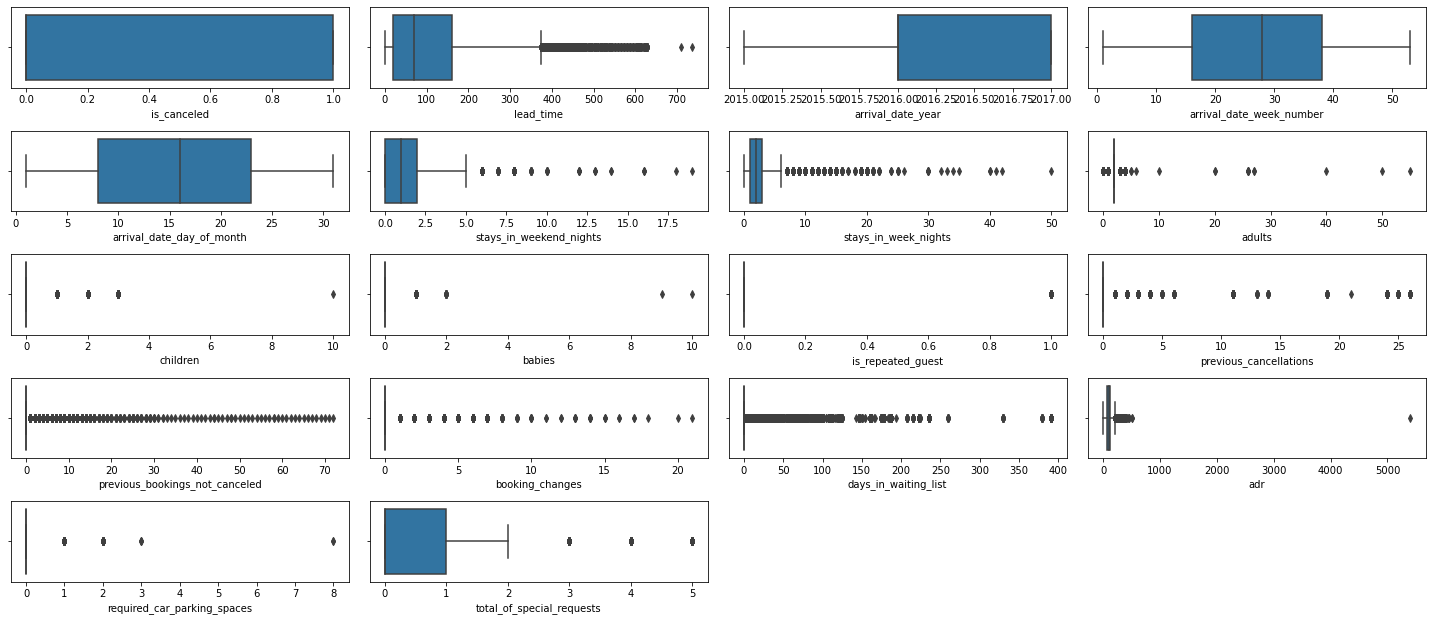

In [16]:
### since the there is no null value anymore in the data now i will check the outliers 

plt.figure(figsize = (20, 10))
x = 1 

for column in df.describe().columns:
    plt.subplot(6,4,x)
    sns.boxplot(df[column])
    x+=1
    
plt.tight_layout()

# we can see that there are many outliers in many of the columns 
# we will handle the outliers by binning the columns that has outliers in it 
# and from the box plot there are columns that has a random value like 0 number of adults 
# and negative amount of adr 
# there's one value of adr that's above 5000 and there's only 1 data point since it so random we will drop that one outliers in
# the adr colummn
# according to : 
# https://www.statista.com/statistics/545281/daily-hotel-rates-lisbon/#:~:text=This%20statistic%20shows%20the%20average,again%20in%202018%20and%202019.

# the average ADR for hotel in lisbon is around 91 - 114 in 2017
# while acccording to :
# https://es.christie.com/christieMediaLibraries/christieSpain/PDFs-Publications/Portugal-Hotel-Market-2018_VF.pdf?ext=.pdf

# the algarve region ADR is 83 

# since this data comes from both region and knowing the avg ADR is less than 5000 we will be dropping the row that has more than
# 5000 euro ADR


### Adult Abnormal Value

In [17]:
# since it's impossible to have 0 adults to book a hotel room 

df.drop(labels = df[df['adults'] == 0].index, axis = 0, inplace = True)
df[df['adults'] == 0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date


### ADR Abnormal Value

In [18]:
# there are a value of a adr columns that below 0 since it is impossible for hotel to owe money to the guest 
df[df['adr'] <0]


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
14969,Resort Hotel,0,195,2017,March,10,5,4,6,2,0.0,0,BB,GBR,Groups,Direct,1,0,2,A,H,2,No Deposit,0,Transient-Party,-6.38,0,0,Check-Out,2017-03-15


In [19]:
df = df.drop(df[df.adr < 0].index)
df[df['adr'] < 0]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date


In [20]:
df = df.drop(df[df.adr > 5000].index)
df[df['adr']> 5000]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date


## Preparation 


### Arrival Columns 


In [21]:
## getting bookin  Arrival date as Date time object 

df['arrival_date'] = df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'] + '-' + df['arrival_date_day_of_month'].astype(str)
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01


In [22]:
## getting arrival month 

df['arrival_month'] = df['arrival_date'].dt.month
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,7


In [23]:
### getting arrival day

df['arrival_day'] = df['arrival_date'].dt.day_name()
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,arrival_day
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,7,Wednesday


In [24]:
df['month_year'] = pd.to_datetime(df['arrival_date']).dt.to_period('M')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,arrival_day,month_year
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday,2015-07
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday,2015-07
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,7,Wednesday,2015-07


### Total Stays Column

getting the total stays column by adding the weekday stays and the weekend stays 

In [25]:
df['total_stays'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,arrival_day,month_year,total_stays
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday,2015-07,1
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday,2015-07,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,7,Wednesday,2015-07,2


In [26]:
df[df['total_stays'] == 0]

# this is a little randomness of the data as well since you won't be able to make a booking at the arrival date and checkout on 
# the same day

# many OTA (booking.com, traveloka won't allow you to do this however hilton hotel allow you to do this )
# so we will keep the data instead of dropping it 

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,arrival_day,month_year,total_stays
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07,0
167,Resort Hotel,0,111,2015,July,28,6,0,0,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,H,0,No Deposit,0,Transient,0.0,0,2,Check-Out,2015-07-06,2015-07-06,7,Monday,2015-07,0
168,Resort Hotel,0,0,2015,July,28,6,0,0,1,0.0,0,BB,PRT,Direct,Direct,0,0,0,E,H,0,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-06,2015-07-06,7,Monday,2015-07,0
196,Resort Hotel,0,8,2015,July,28,7,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,0,Transient,0.0,0,1,Check-Out,2015-07-07,2015-07-07,7,Tuesday,2015-07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115483,City Hotel,0,15,2017,July,27,6,0,0,1,0.0,0,SC,FRA,Direct,Direct,0,0,0,A,A,0,No Deposit,0,Transient-Party,0.0,0,0,Check-Out,2017-07-06,2017-07-06,7,Thursday,2017-07,0
117701,City Hotel,0,0,2017,August,32,8,0,0,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,1,0,0,A,A,0,No Deposit,0,Transient,0.0,0,0,Check-Out,2017-08-08,2017-08-08,8,Tuesday,2017-08,0
118029,City Hotel,0,0,2017,August,33,14,0,0,2,0.0,0,BB,PRT,Direct,Direct,1,0,0,A,A,0,No Deposit,0,Transient,0.0,0,0,Check-Out,2017-08-14,2017-08-14,8,Monday,2017-08,0
118631,City Hotel,0,78,2017,August,34,23,0,0,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,K,7,No Deposit,0,Transient-Party,0.0,0,0,Check-Out,2017-08-23,2017-08-23,8,Wednesday,2017-08,0


#### References to show that you can book and check out on the same day 



by looking at the picture below it's available that to book hotel on the same day as we check out (not an over night stay in portugal) based on the hilton hotel so we will not be dropping the rows that has 0 total stays ( not an overnight) stay

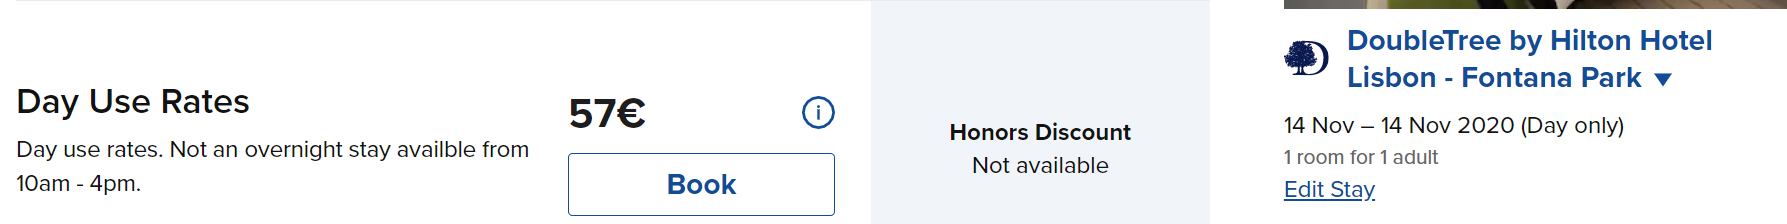

### Guest,  Kids & and Children 


we want to see the total guest of the booking by combining the value of adults children and babies and adding the kids in the booking by combiing the children and the babies, because majority of the bookings sites there's no babies option as well

In [27]:
df['guests'] = df['adults'] + df['children'] + df['babies']
df.head()

# total guest of the hotel booking by adding the babies children and babies

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,arrival_day,month_year,total_stays,guests
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07,0,2.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07,0,2.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday,2015-07,1,1.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday,2015-07,1,1.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,7,Wednesday,2015-07,2,2.0


In [28]:
df['kids'] = df['children'] + df['babies']
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,arrival_day,month_year,total_stays,guests,kids
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07,0,2.0,0.0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07,0,2.0,0.0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday,2015-07,1,1.0,0.0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday,2015-07,1,1.0,0.0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,7,Wednesday,2015-07,2,2.0,0.0


### Meal Columnn

In [29]:
df['meal'].unique()

# we can see from here that there's an undefined value from the dataset 
# however from the explanation from the source of the dataset that undifed meal package is same as SC (No Meal Package)
# so we will replcae the undefined to SC 

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

In [30]:
df['meal'] = df['meal'].str.replace('Undefined', 'SC')
df['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [31]:
# now lets check all the columns description and all the columns boxplot before we moving on to the exploratory data analysis

df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_month,total_stays,guests,kids
count,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000
mean,0.370753,104.070353,2016.156356,27.164407,15.796781,0.926932,2.499029,1.862689,0.100433,0.007951,0.031542,0.087339,0.137328,0.218507,2.325604,101.964460,0.062655,0.570652,6.552381,3.425961,1.971072,0.108383
std,0.483008,106.891161,0.707743,13.598771,8.781164,0.995235,1.897747,0.570064,0.390219,0.097474,0.174777,0.845700,1.499529,0.638068,17.614343,48.053329,0.245546,0.792403,3.089348,2.541649,0.719446,0.404480
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.500000,0.000000,0.000000,4.000000,2.000000,2.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,7.000000,3.000000,2.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,9.000000,4.000000,2.000000,0.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,18.000000,391.000000,510.000000,8.000000,5.000000,12.000000,69.000000,55.000000,10.000000


### Dropping Redundant Column

In [32]:
# since we have columns that that's have almost similar value like children babies, now is combined into kids
# stays in weekend nights and stays in week nights now combined into total stays

# we will be dropping both columns 

df = df.drop(columns = ['stays_in_weekend_nights', 'stays_in_week_nights', 'babies', 'children'])
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_month,arrival_day,month_year,total_stays,guests,kids
0,Resort Hotel,0,342,2015,July,27,1,2,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07,0,2.0,0.0
1,Resort Hotel,0,737,2015,July,27,1,2,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,Transient,0.0,0,0,Check-Out,2015-07-01,2015-07-01,7,Wednesday,2015-07,0,2.0,0.0
2,Resort Hotel,0,7,2015,July,27,1,1,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday,2015-07,1,1.0,0.0
3,Resort Hotel,0,13,2015,July,27,1,1,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,0,Transient,75.0,0,0,Check-Out,2015-07-02,2015-07-01,7,Wednesday,2015-07,1,1.0,0.0
4,Resort Hotel,0,14,2015,July,27,1,2,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,98.0,0,1,Check-Out,2015-07-03,2015-07-01,7,Wednesday,2015-07,2,2.0,0.0


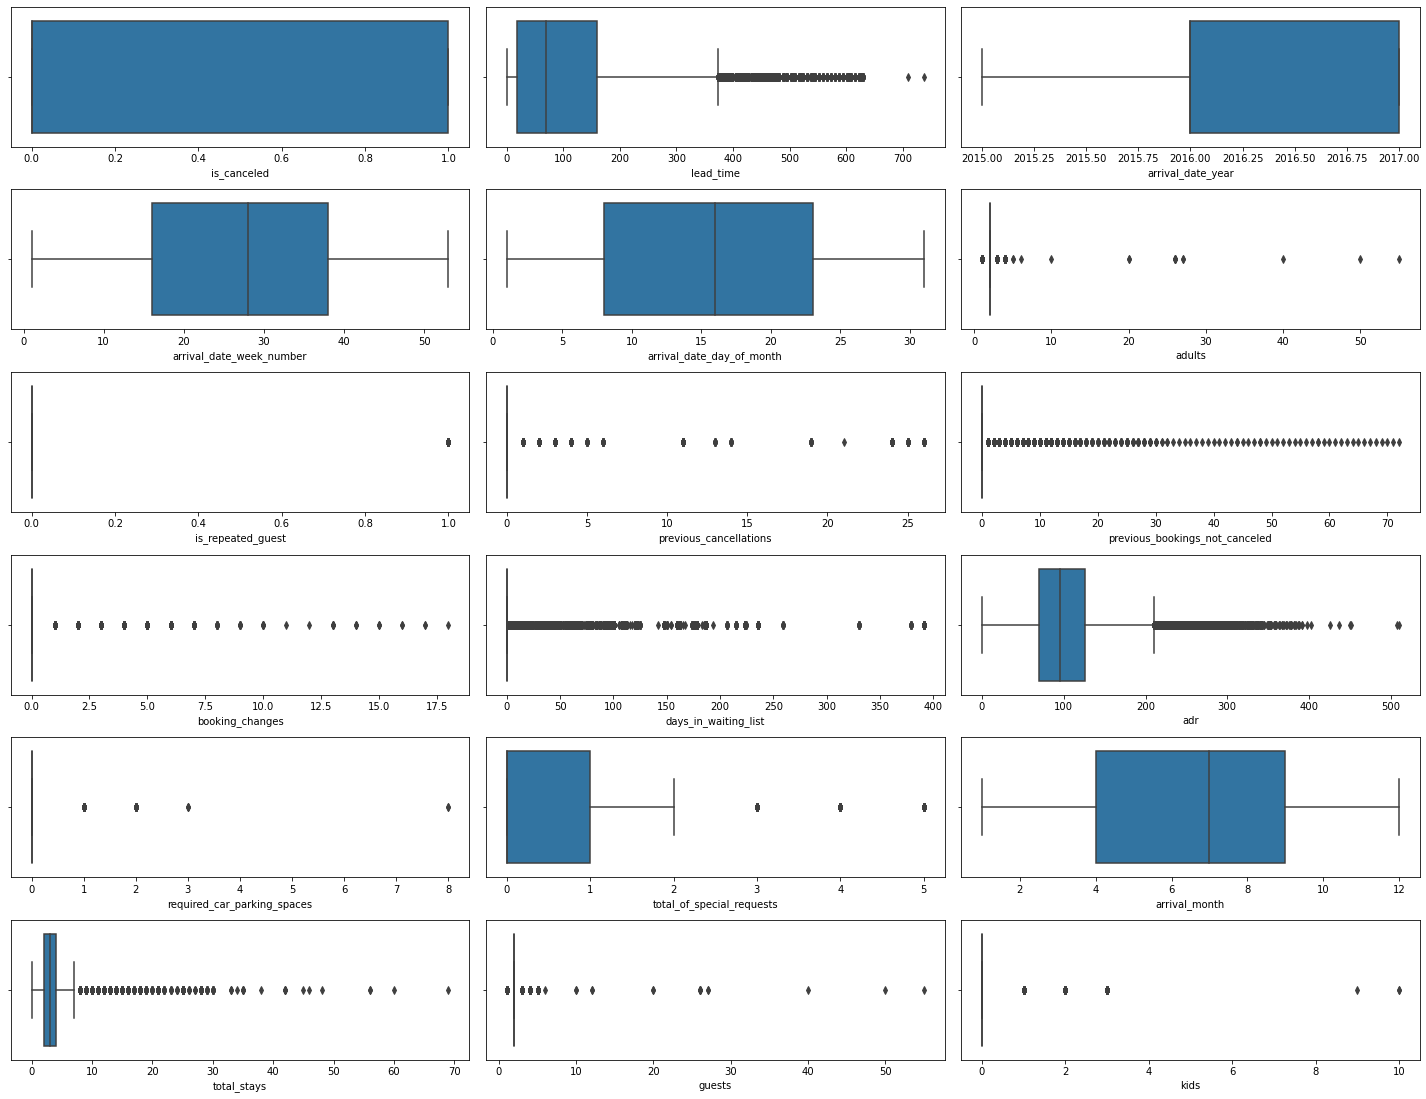

In [33]:
plt.figure(figsize = (20, 20))
x = 1 

for column in df.describe().columns:
    plt.subplot(8,3,x)
    sns.boxplot(df[column])
    x+=1
    
plt.tight_layout()

# as we can see that there are still many outliers in many of the columns 
# we are not going to drop the outliers here as outliers could provide many useful information 
# we will bin in but and create new column and hopefully we will be able to extract some more information by doing that 

In [34]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_month,total_stays,guests,kids
count,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000,118985.000000
mean,0.370753,104.070353,2016.156356,27.164407,15.796781,1.862689,0.031542,0.087339,0.137328,0.218507,2.325604,101.964460,0.062655,0.570652,6.552381,3.425961,1.971072,0.108383
std,0.483008,106.891161,0.707743,13.598771,8.781164,0.570064,0.174777,0.845700,1.499529,0.638068,17.614343,48.053329,0.245546,0.792403,3.089348,2.541649,0.719446,0.404480
min,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.500000,0.000000,0.000000,4.000000,2.000000,2.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,7.000000,3.000000,2.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,9.000000,4.000000,2.000000,0.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,55.000000,1.000000,26.000000,72.000000,18.000000,391.000000,510.000000,8.000000,5.000000,12.000000,69.000000,55.000000,10.000000


In [35]:
df.describe(include = 'O').T

,count,unique,top,freq
hotel,118985,2,City Hotel,78939
arrival_date_month,118985,12,August,13829
meal,118985,4,BB,92018
country,118985,177,PRT,48917
market_segment,118985,8,Online TA,56221
distribution_channel,118985,5,TA/TO,97559
reserved_room_type,118985,9,A,85861
assigned_room_type,118985,11,A,73982
deposit_type,118985,3,No Deposit,104237
customer_type,118985,4,Transient,89336


In [44]:
#since the data has been cleaned it has no more missing value and some randomness to the data we will export this data 
# and do an exploratory data analysis 
# towards the data 

df.to_csv('hotel_cleaned.csv' ,index= False)